# Zernike Aberration Test

This notebook has been used to test aberrations other than defocus to test their effect on the reconstruction quality. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from generateField import calc_offset_field
from math import factorial
from matplotlib import cm

## Define object & system

In [2]:
# Object + source parameters
lambda0 = 633E-9 #m
R = 1*lambda0 #m
z0 = R + 1*lambda0 #m

# Domain size
Lx = 16 * R #m
Ly = 16 * R #m
Lz = 16 * R #m

Nx = 128
Ny = 128
Nz = 128

dx = Lx / Nx #m
dy = Ly / Ny #m
dz = Lz / Nz #m

x = np.linspace(-Lx/2, (Lx-dx)/2, Nx) #m
y = np.linspace(-Ly/2, (Ly-dy)/2, Ny) #m
z = np.linspace(-Lz/2, (Lz-dz)/2, Nz) #m

xx, yy = np.meshgrid(x, y)
xxx, yyy, zzz = np.meshgrid(x, y, z)
RR = np.sqrt(xx**2 + yy**2)
RRR = np.sqrt(xxx**2 + zzz**2)

# Refractive indices for object and medium
n_med = 1
n_obj = 1.01
k_med = (2 * np.pi * n_med) / lambda0

# Optical setup parameters
NA = 0.6
f_0 = NA / (lambda0 * n_med)
f = 17E-3
aperture_radius = f*NA/n_med

# Variables used to setup Zernike calculations, don't need modification
x_pupil = np.linspace(-aperture_radius, aperture_radius, Nx)
y_pupil = np.linspace(-aperture_radius, aperture_radius, Ny)

# grid with lenslet center positions
[XSH,YSH]= np.meshgrid(x_pupil, y_pupil)    # Creation of SH grid

a=XSH[np.sqrt(XSH**2 +YSH**2) <= aperture_radius]
b=YSH[np.sqrt(XSH**2 +YSH**2) <= aperture_radius]
a=np.expand_dims(a, axis=1)
b=np.expand_dims(b, axis=1)
# RefGrid has a first column vector with all X coordinates, a second column vector with all Y coordinates
Refgrid=np.concatenate((a,b), axis=1)

# Define lenslet coordinates in a normalized pupil
Xnorm = Refgrid[:,0]/(aperture_radius)
Ynorm = Refgrid[:,1]/(aperture_radius)

def circ(r):
    
    result = np.zeros(r.shape)
    
    result[r < 1] = 1
    result[r == 1] = 1/2
    
    return result

print("DOF =", lambda0/(2*NA**2))
print("DOF/lambda =", 1/(2*NA**2))

DOF = 8.791666666666667e-07
DOF/lambda = 1.3888888888888888


### Defining functions used later

In [3]:
def calc_defocus_sinogram_aberrated(defocus_distance, n_proj, W_aberration, disableDefocus=False):
    theta=np.linspace(0, 2*np.pi, n_proj)
    sinogram = np.zeros((n_proj, Ny, Nx), dtype=complex)
    
    x_r = defocus_distance * np.cos(theta)
    z_r = -defocus_distance * np.sin(theta)
    
    max_pixel_offset = int(np.ceil(defocus_distance / dx))
    extra_Lx = 2*max_pixel_offset*dx
    
    largeU = calc_offset_field(__name__, lambda0, n_med, n_obj, R, Nx+2*max_pixel_offset, Ny, Lx+extra_Lx, Ly, z0, 0, 8)
    
    for i in tqdm(range(n_proj)):
    
        smallU = scipy.ndimage.shift(largeU, (0, -x_r[i]/dx), mode="constant", cval=np.NAN, order=1)
    
        if max_pixel_offset > 0:
            smallU = smallU[:, max_pixel_offset:-max_pixel_offset]
    
        # Get field with offset to Fourier space to prepare for defocus calculation
        Gdet = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(smallU)))
    
        if disableDefocus == False:
            filter_freq = freqxx**2 + freqyy**2 < n_med**2 / lambda0**2
            W = np.emath.sqrt((n_med**2/lambda0**2 - freqxx**2 - freqyy**2) * filter_freq)
    
            H = np.fft.fftshift(circ(np.sqrt(freqxx**2 + freqyy**2) / f_0)) * np.fft.fftshift(np.exp(-1j * k_med * z_r[i]) * np.exp(1j * (2 * np.pi * z_r[i] * W + k_med * np.fft.fftshift(W_aberration))))
        else:
            H = np.fft.fftshift(circ(np.sqrt(freqxx**2 + freqyy**2) / f_0))
    
        responseFFT = Gdet * H
        response = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(responseFFT)))
    
        sinogram[i] = response
    
    return sinogram

def calc_defocus_sinogram_line_aberrated(defocus_distance_list, n_proj, W_aberration, disableDefocus=False, effectiveNA=False):
    
    for i in range(len(defocus_distance_list)-1):
        assert (defocus_distance_list[i+1] - defocus_distance_list[i] >= 2*R), "Distance between spheres should be larger than 2R!"
    
    sinogram = np.zeros((n_proj, Ny, Nx), dtype=complex)
    
    for defocus_distance in defocus_distance_list:
        sinogram += calc_defocus_sinogram_aberrated(defocus_distance, n_proj, W_aberration, disableDefocus)
        
    # Sinogram [nproj, Ny, Nx]
    return sinogram

def write_sinogram(sinogram):  
    f = open("sinogram_config.dat", "w")
    f.write(f"Nx: {Nx}\n")
    f.write(f"Ny: {Ny}\n")
    f.write(f"dx: {dx}\n")
    f.write(f"dy: {dy}\n")
    f.write(f"dz: {dz}\n")
    f.write(f"nproj: {nproj}\n")
    f.close()

    f = open("sinogram.dat", "w")

    flat_sinogram = np.ravel(sinogram)
    
    for i in range(len(flat_sinogram)):
        f.write(f"{np.real(flat_sinogram[i])}+i{np.imag(flat_sinogram[i])}\n")

    f.close()

def read_sinogram(filename):  
    f = open(filename, "r")

    fft_result = np.zeros((nproj * Ny * Nx), dtype="complex64")

    count = 0
    for line in f:
        real, _,  imag = line.split()
        real = float(real)
        imag = float(imag[1:])
        fft_result[count] = real + 1j * imag
        count += 1

    f.close()

    fft_result = fft_result.reshape((nproj, Ny, Nx))

    return fft_result

def zernike(n,m,x,y):
    rho=np.sqrt(x**2+y**2)
    theta=np.arctan2(y,x)
    if m>n:
        print('Warning: |m| must be less than or equal to n')
    if (n-m)%2!=0:
        print('Warning: all n and m must differ by multiples of 2 (including 0)')    
    if any(rho>1):
        print('Warning: all x and y must be within the unit circle')
    
    Z=np.zeros(len(x))
            
    # radial function
    steps=np.linspace(0, (n-abs(m))/2, int(((n-abs(m))/2)+1), dtype=int)  
    if m>=0:
        if m>0:
            norm=np.sqrt(2*n+2)
        else:
            norm=np.sqrt(n+1)
            
        R=np.zeros(len(x))
        for s in steps:
            factor=factorial(int(n-s))/(factorial(int(s))*factorial(int(0.5*n+0.5*abs(m)-s))*factorial(int(0.5*n-0.5*abs(m)-s)))
            R+=(-1)**s*factor*rho**(n-2*s)
            
        Z=R*norm*np.cos(m*theta)
    
        return Z
    elif m<0:
        norm=np.sqrt(2*n+2)
        R=np.zeros(len(x))
        for s in steps:
            factor=factorial(int(n-s))/(factorial(int(s))*factorial(int(0.5*n+0.5*abs(m)-s))*factorial(int(0.5*n-0.5*abs(m)-s)))
            R+=(-1)**s*factor*rho**(n-2*s)
            
        Z=-R*norm*np.sin(m*theta)
    
        return Z

## Define wavefront aberrations (Zernike coefficients)

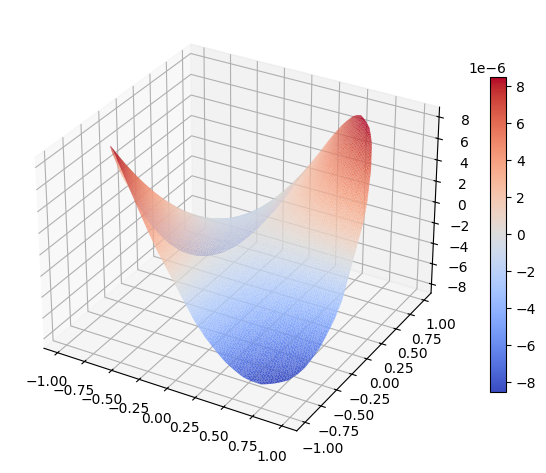

In [4]:
%matplotlib inline

zn = np.array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4])
zm = np.array([0, -1, 1, -2, 0, 2, -3, -1, 1, 3, 0])

# The values commented to the right correspond to a certain Strehl ratio, for the object defined above

astig1 = 0.00000355 #0.9: 0.000001385, 0.8: 0.000002025, 0.7: 0.00000255, 0.6: 0.00000305, 0.5: 0.00000355
astig2 = 0 #0.9: 0.000001385, 0.8: 0.000002025, 0.7: 0.00000255, 0.6: 0.00000305, 0.5: 0.00000355

trefoil1 = 0 #0.9: 0.0000091, 0.8: 0.00001325, 0.7: 0.00001685, 0.6: 0.00002025, 0.5: 0.00002375
trefoil2 = 0 #0.9: 0.0000091, 0.8: 0.00001325, 0.7: 0.00001685, 0.6: 0.00002025, 0.5: 0.00002375
       
coma1 = 0 #0.9: 0.0000000775, 0.8: 0.0000001125, 0.7: 0.000000141, 0.6: 0.0000001675,  0.5: 0.0000001925
coma2 = 0 #0.9: 0.0000000775, 0.8: 0.0000001125, 0.7: 0.000000141, 0.6: 0.0000001675,  0.5: 0.0000001925

spherical = 0 #0.9: 0.0000003625, 0.8: 0.000000525, 0.7: 0.00000066, 0.6: 0.0000007825, 0.5: 0.000000905

zcoeff=np.array([0, 0, 0, astig1, 0, astig2, trefoil1, coma1, coma2, trefoil2, spherical])

def Aberration(zn, zm, zcoef, Xnorm, Ynorm):
    '''
        Calculate the total wavefield aberration as a sum of Zernikes
    '''
    aberration=np.zeros(len(Xnorm))
    for cnt in range(len(zn)):
        aberration+=zcoeff[cnt]*zernike(zn[cnt], zm[cnt], Xnorm, Ynorm)
    return aberration

W_abberation_circ = Aberration(zn, zm, zcoeff, Xnorm, Ynorm)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
pos1 = ax.plot_trisurf(Xnorm, Ynorm, W_abberation_circ, linewidth=0, cmap=cm.coolwarm, antialiased=True)
plt.colorbar(pos1, shrink=0.7)
plt.tight_layout()
plt.show()

W_abberation = np.zeros((Nx, Ny))

RHO_SH = np.sqrt(XSH**2 + YSH**2)

count = 0
for i in range(Nx*Ny):
    if RHO_SH[np.unravel_index(i, RHO_SH.shape, 'F')] < aperture_radius:
        W_abberation[np.unravel_index(i, W_abberation.shape, 'F')] = W_abberation_circ[count]
        count += 1

## Point spread function visualization

Strehl ratio: 0.5001880718985869


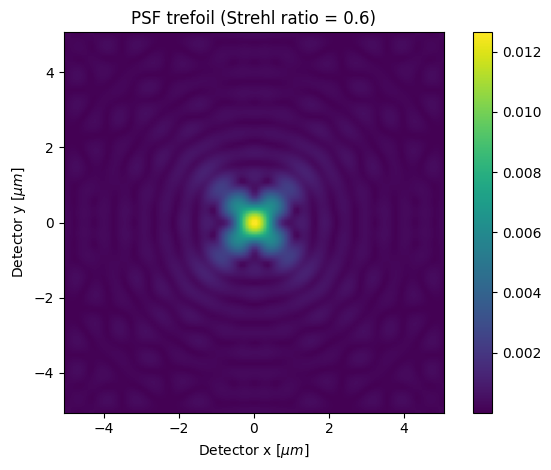

In [5]:
artificial_defocus = 0*lambda0

freqx = np.fft.fftfreq(Nx, d=dx)
freqy = np.fft.fftfreq(Ny, d=dy)

freqxx, freqyy = np.meshgrid(freqx, freqy)

filter_freq = freqxx**2 + freqyy**2 < n_med**2 / lambda0**2
W = np.emath.sqrt((n_med**2/lambda0**2 - freqxx**2 - freqyy**2) * filter_freq)

H = np.fft.fftshift(circ(np.sqrt(freqxx**2 + freqyy**2) / f_0)) * np.fft.fftshift(np.exp(-1j * k_med * artificial_defocus) * np.exp(1j * (2 * np.pi * artificial_defocus * W + k_med * np.fft.fftshift(W_abberation))))
H_no_aberration = np.fft.fftshift(circ(np.sqrt(freqxx**2 + freqyy**2) / f_0)) * np.fft.fftshift(np.exp(-1j * k_med * artificial_defocus) * np.exp(1j * (2 * np.pi * artificial_defocus * W)))

PSF = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H)))
PSF_no_aberration = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H_no_aberration)))

Strehl_ratio = np.square(np.abs(PSF[Nx//2, Ny//2])) / np.square(np.abs(PSF_no_aberration[Nx//2, Ny//2]))

print("Strehl ratio:", Strehl_ratio)

plt.imshow(np.abs(PSF), extent=[-Lx/2*10**6, Lx/2*10**6, -Lz/2*10**6, Lz/2*10**6])
plt.colorbar()
plt.xlabel("Detector x [$\mu m$]")
plt.ylabel("Detector y [$\mu m$]")
plt.title("PSF trefoil (Strehl ratio = 0.6)")
plt.tight_layout()
plt.show()

## Perform filtered backpropagation

In [6]:
nproj = 200
theta=np.linspace(0, 2*np.pi, nproj)

# Only put sphere in the center (0)
defocus_distance_list = np.array([0])

sinogram = calc_defocus_sinogram_line_aberrated(defocus_distance_list, nproj, W_abberation)
sinogram_ideal = calc_defocus_sinogram_line_aberrated(defocus_distance_list, nproj, np.zeros(W_abberation.shape))

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 937.21it/s]


In [ ]:
lambda0_px = lambda0 / dz
lD = z0 / dz

km_px = (2 * np.pi * n_med) / lambda0_px

kx_px = 2 * np.pi * np.fft.fftfreq(Nx)
ky_px = 2 * np.pi * np.fft.fftfreq(Ny)

kx_px = kx_px.reshape(1, -1)
ky_px = ky_px.reshape(-1, 1)

filter_klp_px = (kx_px**2 + ky_px**2 < km_px**2)

M = 1. / km_px * np.sqrt((km_px**2 - kx_px**2 - ky_px**2) * filter_klp_px)

prefactor = -1j * km_px / (2 * np.pi)
prefactor *= 2*np.pi / nproj
prefactor *= np.abs(kx_px) * filter_klp_px
prefactor *= np.exp(-1j * km_px * (M-1) * lD)

zv = z.reshape(-1, 1, 1) / dz

Mp = M.reshape(Ny, Nx)

filter2 = np.exp(1j * zv * km_px * (Mp - 1))

projection_aberrated = np.fft.fft2(sinogram, axes=(1,2)) * prefactor / (dx * dy)
projection_ideal = np.fft.fft2(sinogram_ideal, axes=(1,2)) * prefactor / (dx * dy)

interpolation_order = 1
objectFD_aberrated = np.zeros((Nz, Ny, Nx), dtype=complex)
objectFD_ideal = np.zeros((Nz, Ny, Nx), dtype=complex)

for i in tqdm(range(nproj)):

    rotated_projection_aberrated = np.zeros((Nz, Ny, Nx), dtype="complex64")
    rotated_projection_ideal = np.zeros((Nz, Ny, Nx), dtype="complex64")

    for p in range(len(zv)):
        rotated_projection_aberrated[p, :, :] = np.fft.ifft2(projection_aberrated[i] * filter2[p], axes=(0,1))
        rotated_projection_ideal[p, :, :] = np.fft.ifft2(projection_ideal[i] * filter2[p], axes=(0,1))

    rotated_projection_aberrated = scipy.ndimage.rotate(
        rotated_projection_aberrated, -theta[i] * 180 / np.pi,
        reshape=False, mode="constant", cval=0,
        axes=(0, 2), order=interpolation_order)
    
    rotated_projection_ideal = scipy.ndimage.rotate(
        rotated_projection_ideal, -theta[i] * 180 / np.pi,
        reshape=False, mode="constant", cval=0,
        axes=(0, 2), order=interpolation_order)

    objectFD_aberrated += rotated_projection_aberrated
    objectFD_ideal += rotated_projection_ideal
        

ri = n_med * np.sqrt(objectFD_aberrated / k_med**2 + 1)
ri_ideal = n_med * np.sqrt(objectFD_ideal / k_med**2 + 1)

 59%|████████████████████████▏                | 118/200 [00:28<00:19,  4.14it/s]

In [ ]:
%matplotlib inline

plt.plot(x*10**6, np.real(ri_ideal[Nz//2, Ny//2, :])-1, label="Ideal sphere")
plt.plot(x*10**6, np.real(ri[Nz//2, Nz//2, :])-1, label="Aberrated sphere")
plt.xlabel("x [$\mu m$]")
plt.ylabel("$\Delta n$ [-]")
plt.title("Aberration comparison (Astigmatism, Strehl ratio = 0.5)")
plt.legend()
plt.grid()
plt.show()